In [69]:
import os

if os.name == "nt":
    os.system(".\\activate.bat")
    os.system("pip install -r requirements.txt")
else:
    os.system("source ./activate.sh")
    os.system("pip3 install -r requirements.txt")


In [70]:
# pip install -r requirements.txt

import pandas as pd
import numpy as np
from requests import get
from dotenv import load_dotenv

from os import walk, path, environ
from typing import Iterable, Union


load_dotenv()


False

---
# Gethering data
1. get the `image_predictions.tsv` file using the requests library
2. read the `twitter_archive_enhanced.csv` file using pandas
3. get the `tweet_json.txt` using the tweepy library



### 1. Downloading the `image_predictions.tsv` file

In [71]:


URL = r"https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
file_name = "image_predictions.tsv"

def download(url, file_name):
    response = get(url)

    match response.status_code:
        case 200:
            print("downloaded successfully")
            with open(path.join("data", file_name), "w") as f:
                if f.writable():
                    f.write(response.text)
        case 400:
            print("bad request")
        case 404:
            print("couldn't find the file, udacity removed it")
        case 500:
            print("udacity broke something")
        case _:
            print("bro! you messed up, BADLY")

download(URL, file_name)

downloaded successfully




### 2. reading the `twitter_archive_enhanced.csv` file
#### I downloaded the file manually



### 3. using tweepy to get `tweet_json.json`

##### Since Mr.Elon bought twitter, This won't work, so I won't bother running this code
##### I just downloaded the data manually

In [72]:
# import tweepy
# from tweepy import OAuthHandler
# import json
# from timeit import default_timer as timer

# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)
# tweet_ids = df_1.tweet_id.values
# len(tweet_ids)

# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)

In [73]:
url = "https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt"
file_name = "tweet_json.json"

download(url, file_name)

downloaded successfully




## Reading the data into data frames

In [74]:
EXTENSIONS = {
    "t": lambda file: pd.read_csv(file, sep="\t"),
    "c": lambda file: pd.read_csv(file, sep=","),
    "s": lambda file: pd.read_csv(file, sep=" "),
    "j": lambda file: pd.read_json(file, lines=True),
}

def read_data(files: Union[Iterable[str], str]):
    if isinstance(files, str):
        files = [files]

    supported_files = (
        file for file in files
        if file.split(".")[-1][0] in EXTENSIONS
    )

    data_frames = [
        EXTENSIONS[file.split(".")[-1][0]](file)
        for file in supported_files
    ]

    unsupported_files = (
        file for file in files
        if file.split(".")[-1][0] not in EXTENSIONS
    )

    for file in unsupported_files:
        print(f"Unsupported file extension: {file.split('.')[-1]}", flush=True)

    return data_frames


In [75]:
root, dirs, files = next(walk("data"))
print(files)
files = (path.join(root, file) for file in files)

data = read_data(files)

predictions_df, tweet_json_df, twitter_enhanced_df = data



['image_predictions.tsv', 'tweet_json.json', 'twitter-archive-enhanced.csv']


---
# Assessing data

In [76]:

twitter_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

In [77]:
twitter_enhanced_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,NaN,NaN,NaN
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,NaN,NaN,NaN,NaN
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,NaN,NaN,NaN,NaN
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,NaN,NaN,NaN,NaN


In [78]:
twitter_enhanced_df["rating_denominator"].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

the denominator should always be 10, let's check the numerators

In [79]:
unreal_ratings = twitter_enhanced_df.loc[
    twitter_enhanced_df["rating_denominator"] != 10,
    ["rating_numerator", "rating_denominator"]
].index

In [80]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [81]:
tweet_json_df

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2350,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,311,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2351,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,128,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2352,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,132,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [82]:
tweet_json_df["possibly_sensitive"].unique()

array([ 0., nan])

In [83]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [84]:
predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


### Quality
1. `twitter_enhanced_df` table: names are sometimes `a` or `an` and that is due to the `This is a` text
2. `twitter_enhanced_df` table: `timestamp` and `retweeted_status_timestamp` are objects
3. `twitter_enhanced_df` table: `in_reply_to_user_id` and `in_reply_to_status_id` are floats not ints
4. `twitter_enhanced_df` table: `retweeted_status_id` and `retweeted_status_user_id` are floats not ints
5. `twitter_enhanced_df` table: some indicies have unreal ratings
6. `tweet_json_df` table: `geo`, `place`, `contributors` and `coordinates` columns are just not present
7. `tweet_json_df` table: `quoted_status_id_str` is a float64
8. `tweet_json_df` table: `id_str` is an int64
9. `tweet_json_df` table: `possibly_sensitive` is either a 0.0 or Nan

### Tidness
1. `twitter_enhanced_df` table: `doggo`, `floofer`, `pupper` and `puppo` could have been in a nullable `nickname` column
2. `tweet_json_df` table: it's just too big and contains a lot of unessacry data

---
# Cleaning data

## Define



### Quality issues

#### 1. `twitter_enhanced_df` table: names are sometimes `a` or `an` and that is due to the `This is a` text
- replace `Nan` or `a` or `an` with `-` for ease

#### 2. `twitter_enhanced_df` table: `timestamp` and `retweeted_status_timestamp` are objects
- convert them to `datetime64[ns]`

#### 3. `twitter_enhanced_df` table: `in_reply_to_user_id` and `in_reply_to_status_id` are floats not ints
- convert them to `int64`

#### 4. `twitter_enhanced_df` table: `retweeted_status_id` and `retweeted_status_user_id` are floats not ints
- convert them to `int64`

#### 5. `twitter_enhanced_df` table: some indicies have unreal ratings
- drop them

#### 6. `tweet_json_df` table: `geo`, `place`, `contributors` and `coordinates` columns are just not present
- drop the since there is no need for them

#### 7. `tweet_json_df` table: `quoted_status_id_str` is a float64
- convert it into an `int64`

#### 8. `tweet_json_df` table: `id_str` is an int64
- convert it to an object

#### 9. `tweet_json_df` table: `possibly_sensitive` is either a 0.0 or Nan
- drop it since there is no use for it

### Tidness issues

#### 1. `twitter_enhanced_df` table: `doggo`, `floofer`, `pupper` and `puppo` could have been in a nullable `nickname` column
- make a nickname column and remove the other columns

#### 2. `tweet_json_df` table: it's just too big and contains a lot of unessacry data
- remove all unessacry data

## Code

In [85]:
clean_twitter_enhanced_df = twitter_enhanced_df.copy()
clean_tweet_json_df = tweet_json_df.copy()


### Quality

#### 1. `twitter_enhanced_df` table: names are sometimes `a` or `an` and that is due to the `This is a` text
- replace `Nan` or `a` or `an` with `-` for ease

In [86]:
clean_twitter_enhanced_df.loc[
    clean_twitter_enhanced_df["name"].isin(["a", "an", "the"]) |
    clean_twitter_enhanced_df["name"].isna(), 
    "name"
] = "-"

#### 2. `twitter_enhanced_df` table: `timestamp` and `retweeted_status_timestamp` are objects
- convert them to `datetime64[ns]`

In [87]:
clean_twitter_enhanced_df["timestamp"] = pd.to_datetime(clean_twitter_enhanced_df["timestamp"], errors="coerce")
clean_twitter_enhanced_df["retweeted_status_timestamp"] = pd.to_datetime(clean_twitter_enhanced_df["retweeted_status_timestamp"], errors="coerce")


#### 3. `twitter_enhanced_df` table: `in_reply_to_user_id` and `in_reply_to_status_id` are floats not ints
- convert them to `int64`

In [88]:
clean_twitter_enhanced_df["in_reply_to_user_id"] = clean_twitter_enhanced_df["in_reply_to_user_id"].astype("Int64")
clean_twitter_enhanced_df["in_reply_to_status_id"] = clean_twitter_enhanced_df["in_reply_to_status_id"].astype("Int64")

#### 4. `twitter_enhanced_df` table: `retweeted_status_id` and `retweeted_status_user_id` are floats not ints
- convert them to `int64`

In [89]:
clean_twitter_enhanced_df["retweeted_status_id"] = clean_twitter_enhanced_df["retweeted_status_id"].astype("Int64")
clean_twitter_enhanced_df["retweeted_status_user_id"] = clean_twitter_enhanced_df["retweeted_status_user_id"].astype("Int64")

#### 5. `twitter_enhanced_df` table: some indicies have unreal ratings
- drop them

In [90]:
# clean_twitter_enhanced_df.drop(index=unreal_ratings, inplace=True)
# clean_twitter_enhanced_df.reset_index(drop=True, inplace=True)

# I will leave them for the second iteration to remove the rows from all dataset

#### 6. `tweet_json_df` table: `geo`, `place`, `contributors` and `coordinates` columns are just not present
- drop the since there is no need for them

In [91]:
clean_tweet_json_df.drop(columns=["geo", "place", "contributors", "coordinates"], inplace=True)

#### 7. `tweet_json_df` table: `quoted_status_id_str` is a float64
- convert it into an `int64`

In [92]:
clean_tweet_json_df["quoted_status_id_str"] = clean_tweet_json_df["quoted_status_id_str"].astype("Int64")

#### 8. `tweet_json_df` table: `id_str` is an int64
- convert it to an object

In [93]:
clean_tweet_json_df["id_str"] = clean_tweet_json_df["id_str"].astype("object")

#### 9. `tweet_json_df` table: `possibly_sensitive` is either a 0.0 or Nan
- drop it since there is no use for it

In [94]:
clean_tweet_json_df.drop(columns=["possibly_sensitive"], inplace=True)

### Tidness

#### 1. `twitter_enhanced_df` table: `doggo`, `floofer`, `pupper` and `puppo` could have been in a nullable `nickname` column

In [95]:
clean_twitter_enhanced_df["nickname"] = twitter_enhanced_df[["doggo", "floofer", "pupper", "puppo"]].bfill(axis=1).iloc[:, 0]
clean_twitter_enhanced_df.drop(columns=["doggo", "floofer", "pupper", "puppo"], inplace=True)

#### 2. `tweet_json_df` table: it's just too big and contains a lot of unessacry data

In [96]:
unnecessary_columns = [
    "in_reply_to_status_id",
    "in_reply_to_status_id_str",
    "in_reply_to_user_id",
    "in_reply_to_user_id_str",
    "in_reply_to_screen_name",
    "quoted_status_id",
    "quoted_status_id_str",
    "quoted_status",
    "id_str"
]
clean_twitter_enhanced_df.drop(columns=[col for col in unnecessary_columns if col in twitter_enhanced_df.columns], inplace=True)


## Tests

In [97]:

try:
    bad_data = clean_twitter_enhanced_df.loc[
        clean_twitter_enhanced_df["name"].isin(["a", "an", "the"]) |
        clean_twitter_enhanced_df["name"].isna(),
        "name"
    ]
    assert len(bad_data) <= 1, f"{bad_data}"


    assert clean_twitter_enhanced_df["timestamp"].dtype == "datetime64[ns, UTC]", "Test 2 Failed"


    if "in_reply_to_user_id" in clean_twitter_enhanced_df.columns:
        assert clean_twitter_enhanced_df["in_reply_to_user_id"].dtype == "Int64", "Test 3 Failed"

    if "in_reply_to_status_id" in clean_twitter_enhanced_df.columns:
        assert clean_twitter_enhanced_df["in_reply_to_status_id"].dtype == "Int64", "Test 3 Failed"


    if "retweeted_status_id" in clean_twitter_enhanced_df.columns:
        assert clean_twitter_enhanced_df["retweeted_status_id"].dtype == "Int64", "Test 4 Failed"

    if "retweeted_status_user_id" in clean_twitter_enhanced_df.columns:
        assert clean_twitter_enhanced_df["retweeted_status_user_id"].dtype == "Int64", "Test 4 Failed"



    assert "geo" not in clean_tweet_json_df.columns, "Test 5 Failed"
    assert "place" not in clean_tweet_json_df.columns, "Test 5 Failed"
    assert "contributors" not in clean_tweet_json_df.columns, "Test 5 Failed"
    assert "coordinates" not in clean_tweet_json_df.columns, "Test 5 Failed"


    if "quoted_status_id_str" in clean_tweet_json_df.columns:
        assert clean_tweet_json_df["quoted_status_id_str"].dtype == "Int64", "Test 6 Failed"


    if "id_str" in clean_tweet_json_df.columns:
        assert clean_tweet_json_df["id_str"].dtype == "object", "Test 7 Failed"


    assert "possibly_sensitive" not in clean_tweet_json_df.columns, "Test 8 Failed"


    for col in unnecessary_columns:
        assert col not in clean_twitter_enhanced_df.columns, f"Tidness Failed: {col} still present"

except AssertionError as e:
    print("\033[1;31m", f"Failed at {e}".removesuffix("Failed"), "\033[0m", sep="")

else:
    print("\033[1;32mAll tests passed!\033[0m")



All tests passed!


In [98]:
merged_df = pd.merge(predictions_df, clean_tweet_json_df, left_on="tweet_id", right_on="id", how="left")
df = pd.merge(merged_df, clean_twitter_enhanced_df, left_on="tweet_id", right_on="tweet_id", how="left")

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2075 non-null   int64              
 1   jpg_url                        2075 non-null   object             
 2   img_num                        2075 non-null   int64              
 3   p1                             2075 non-null   object             
 4   p1_conf                        2075 non-null   float64            
 5   p1_dog                         2075 non-null   bool               
 6   p2                             2075 non-null   object             
 7   p2_conf                        2075 non-null   float64            
 8   p2_dog                         2075 non-null   bool               
 9   p3                             2075 non-null   object             
 10  p3_conf                 

Looks like there is some re-cleaning required

## Defining

#### 1. Missing data
- drop all columns with less than a 100 entries

#### 2. Weird pattern
- after merge it looks like every column with 2073 have the corrected value in it's clone column,
- the pattern seems to only occur in `df.iloc[[1413, 2055]]`, let's just drop'em

#### 3. List type column
- `display_text_range` is unhashable
- make an upper bound column since all lower bound is 0

#### 4. Unnesacery columns
- `turanicated`, `is_quote_status` are always `False`
- drop it since there is no need

#### 5. Tidiness
- `entities` column would be better of as it's own dataframe
- add a percentage column for ease of analysis

#### 6. Lookout for outliers
- remove rows with outliers or refil them

## Coding

1. Missing data

In [100]:
df.drop(columns=[col for col in df.columns if df[col].count() < 100], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2075 non-null   int64              
 1   jpg_url                        2075 non-null   object             
 2   img_num                        2075 non-null   int64              
 3   p1                             2075 non-null   object             
 4   p1_conf                        2075 non-null   float64            
 5   p1_dog                         2075 non-null   bool               
 6   p2                             2075 non-null   object             
 7   p2_conf                        2075 non-null   float64            
 8   p2_dog                         2075 non-null   bool               
 9   p3                             2075 non-null   object             
 10  p3_conf                 

2. Weird pattern

In [101]:
df.drop(index=[1413, 2055] + list(df.loc[df["rating_denominator"] != 10].index), axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

3. List type column

In [102]:
df["display_text_range"] = df["display_text_range"].apply(lambda x: x[1])
df.rename({"display_text_range": "display_text_max"});


4. Unnesacery columns

In [103]:
df.drop(columns=["truncated", "is_quote_status"], inplace=True)
df.reset_index(inplace=True, drop=True)

5. Tidiness (get media into it's own dataframe)

In [104]:
# since I only need the media
df.drop(columns=("entities"), inplace=True)
df.reset_index(inplace=True, drop=True)


In [105]:
media = (
    {k: v for k, v in media.items() if k != "sizes"}
    for sublist in df["extended_entities"].dropna().apply(lambda x: x.get("media", []))
    for media in sublist
)

media_df = pd.DataFrame(media)

In [106]:
media_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2920 non-null   int64  
 1   id_str                 2920 non-null   object 
 2   indices                2920 non-null   object 
 3   media_url              2920 non-null   object 
 4   media_url_https        2920 non-null   object 
 5   url                    2920 non-null   object 
 6   display_url            2920 non-null   object 
 7   expanded_url           2920 non-null   object 
 8   type                   2920 non-null   object 
 9   source_status_id       121 non-null    float64
 10  source_status_id_str   121 non-null    object 
 11  source_user_id         121 non-null    float64
 12  source_user_id_str     121 non-null    object 
 13  video_info             83 non-null     object 
 14  additional_media_info  77 non-null     object 
dtypes: f

In [107]:
media_df["lower_indices"] = media_df["indices"].apply(lambda x: x[0])
media_df["upper_indices"] = media_df["indices"].apply(lambda x: x[1])

media_df.drop(columns=["indices", "additional_media_info", "source_user_id_str", "source_status_id_str", "id_str", "video_info"], inplace=True)

In [108]:
df.fillna({"nickname": "-"}, inplace=True)

In [109]:
df["percentage"] = ((df["rating_numerator"] / 10) * 100).astype("float32")
df["percentage"]

0        80.0
1        70.0
2        90.0
3        60.0
4        50.0
        ...  
2050    120.0
2051    130.0
2052    120.0
2053    130.0
2054    130.0
Name: percentage, Length: 2055, dtype: float32

### Now we remove the duplicates

In [110]:
columns_to_keep = [
    "tweet_id", "jpg_url", "img_num", "p1", "p1_conf", "p1_dog",
    "p2", "p2_conf", "p2_dog", "p3", "p3_conf", "p3_dog",
    "created_at", "retweet_count",
    "favorite_count", "text", "rating_numerator", "rating_denominator", "percentage", "name", "nickname"
]


df.drop(columns=[col for col in df.columns if col not in columns_to_keep], inplace=True)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2055 non-null   int64              
 1   jpg_url             2055 non-null   object             
 2   img_num             2055 non-null   int64              
 3   p1                  2055 non-null   object             
 4   p1_conf             2055 non-null   float64            
 5   p1_dog              2055 non-null   bool               
 6   p2                  2055 non-null   object             
 7   p2_conf             2055 non-null   float64            
 8   p2_dog              2055 non-null   bool               
 9   p3                  2055 non-null   object             
 10  p3_conf             2055 non-null   float64            
 11  p3_dog              2055 non-null   bool               
 12  created_at          2055 non-null 

6. Lookout for outliers

In [112]:
unreal_ratings = df.loc[~df["rating_numerator"].isin(range(1, 21))].index


df.drop(index=unreal_ratings, inplace=True)
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2048 non-null   int64              
 1   jpg_url             2048 non-null   object             
 2   img_num             2048 non-null   int64              
 3   p1                  2048 non-null   object             
 4   p1_conf             2048 non-null   float64            
 5   p1_dog              2048 non-null   bool               
 6   p2                  2048 non-null   object             
 7   p2_conf             2048 non-null   float64            
 8   p2_dog              2048 non-null   bool               
 9   p3                  2048 non-null   object             
 10  p3_conf             2048 non-null   float64            
 11  p3_dog              2048 non-null   bool               
 12  created_at          2048 non-null 

---
# Storing the data

## First we divide the data again

In [113]:
predictions_df.drop(columns=["tweet_id"], inplace=True)

In [117]:
df_cols = set(df.columns)

predictions_cols = set(predictions_df.columns) & df_cols
tweet_cols = set(clean_tweet_json_df.columns) & df_cols
twitter_cols = set(clean_twitter_enhanced_df.columns) & df_cols

try:
    assert len(tweet_cols & df_cols) + len(predictions_cols & df_cols) + len(twitter_cols & df_cols) + 1 ==  len(df_cols), f"Non-equal columns expected {len(df_cols)}, but got {len(tweet_cols & df_cols) + len(predictions_cols & df_cols) + len(twitter_cols & df_cols) + 1}"
except AssertionError as e:
    print("\033[1;31m", f"Failed at {e}".removesuffix("Failed"), "\033[0m", sep="")
else:
    print("\033[1;32mAll tests passed!\033[0m")

All tests passed!


In [118]:
master_pridections = df[list(predictions_cols)]
master_tweets = df[list(tweet_cols)]
master_twitter = df[list(twitter_cols) + ["percentage"]]


## I will make an SQLite database

In [119]:
import sqlite3
conn = sqlite3.connect("db.sqlite3")

In [120]:
master_pridections.to_sql("predictions", conn, if_exists="replace", index=False)
master_tweets.to_sql("tweets", conn, if_exists="replace", index=False)
master_twitter.to_sql("twitter", conn, if_exists="replace", index=False)
media_df.to_sql("media", conn, if_exists="replace", index=False)

2920

In [121]:
conn.close()

---
# Visuals and Insights

In [122]:
del df, twitter_enhanced_df, clean_tweet_json_df, media_df, merged_df, tweet_json_df, predictions_df, clean_twitter_enhanced_df

In [123]:
from sqlite3 import connect
conn = connect("db.sqlite3")

In [124]:
twitter_df = pd.read_sql("SELECT * FROM twitter", con=conn)
tweets_df = pd.read_sql("SELECT * FROM tweets", con=conn)
predictions_df = pd.read_sql("SELECT * FROM predictions", con=conn)
media_df = pd.read_sql("SELECT * FROM media", con=conn)

In [125]:
conn.close()

In [126]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating_numerator    2048 non-null   int64  
 1   text                2048 non-null   object 
 2   tweet_id            2048 non-null   int64  
 3   rating_denominator  2048 non-null   int64  
 4   name                2048 non-null   object 
 5   nickname            2048 non-null   object 
 6   percentage          2048 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 112.1+ KB


In [127]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   favorite_count  2048 non-null   float64
 1   retweet_count   2048 non-null   float64
 2   created_at      2048 non-null   object 
dtypes: float64(2), object(1)
memory usage: 48.1+ KB


In [128]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   p1_conf  2048 non-null   float64
 1   p3_dog   2048 non-null   int64  
 2   p2_dog   2048 non-null   int64  
 3   p2       2048 non-null   object 
 4   p3_conf  2048 non-null   float64
 5   p1       2048 non-null   object 
 6   jpg_url  2048 non-null   object 
 7   p1_dog   2048 non-null   int64  
 8   p3       2048 non-null   object 
 9   p2_conf  2048 non-null   float64
 10  img_num  2048 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 176.1+ KB


In [129]:
import matplotlib.pyplot as plt

## Insights
1. How much people retweet and like vs the rating
2. How much does the time affects the likes
3. What is the most famous nickname


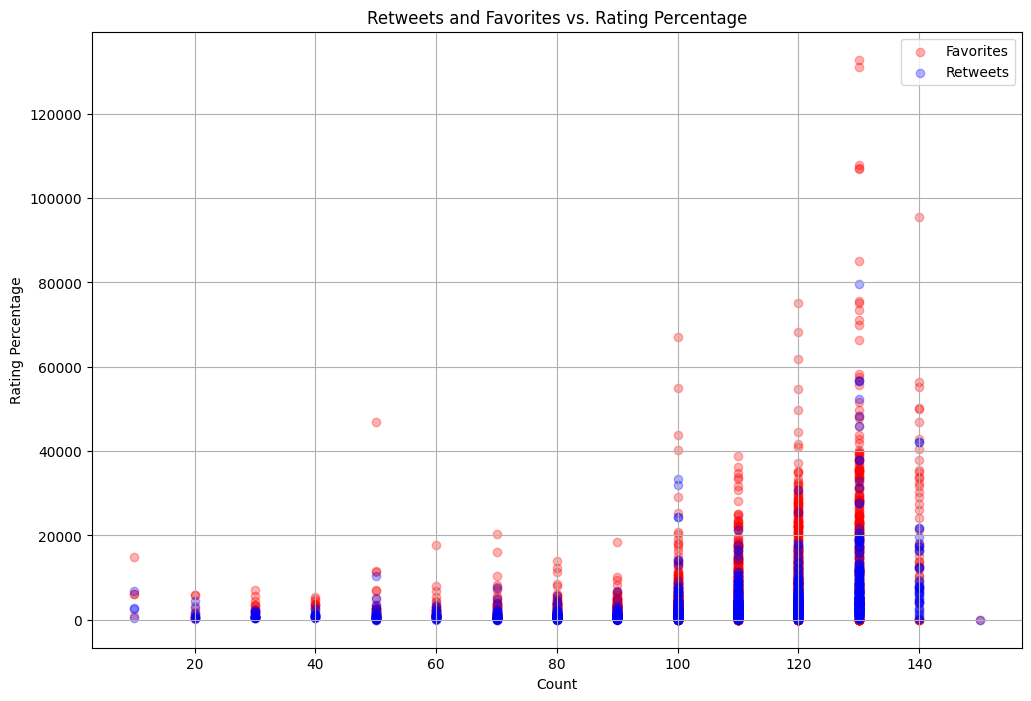

In [130]:

plt.figure(figsize=(12, 8))

# Scatter plot for Retweets
plt.scatter(twitter_df["percentage"], tweets_df["favorite_count"], color="red", label="Favorites", alpha=0.3)
plt.scatter(twitter_df["percentage"], tweets_df["retweet_count"], color="blue", label="Retweets", alpha=0.3)

# Scatter plot for Favorites

plt.title("Retweets and Favorites vs. Rating Percentage")
plt.xlabel("Count")
plt.ylabel("Rating Percentage")
plt.legend()
plt.grid(True)
plt.show()



Looks like there is a strong relation between favs and retweets with the ratings

### Now let's have look on time vs retweets and favorites

In [131]:
ratings_time = pd.DataFrame()
ratings_time["timestamp"] = pd.to_datetime(tweets_df["created_at"])
ratings_time["rating"] = twitter_df["percentage"]

ratings_time = ratings_time.resample("ME", on="timestamp")["rating"].mean()

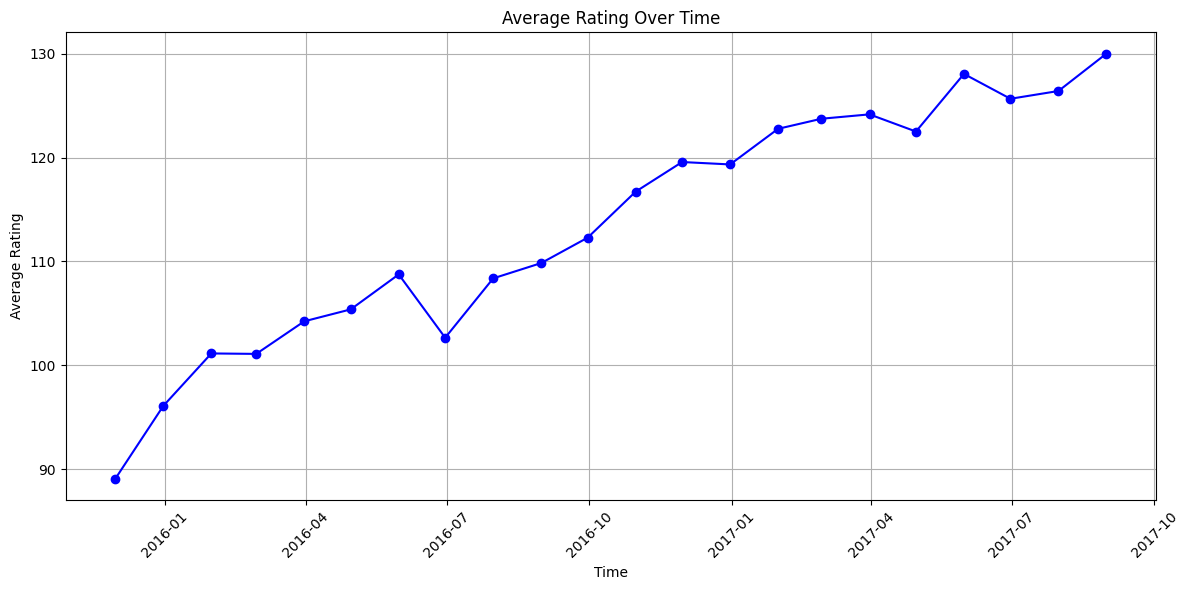

In [132]:


plt.figure(figsize=(12, 6))
plt.plot(ratings_time.index, ratings_time, marker="o", linestyle="-", color="b")
plt.xlabel("Time")
plt.ylabel("Average Rating")
plt.title("Average Rating Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

Looks like people are loving twitter

### Let's see our good boys' names

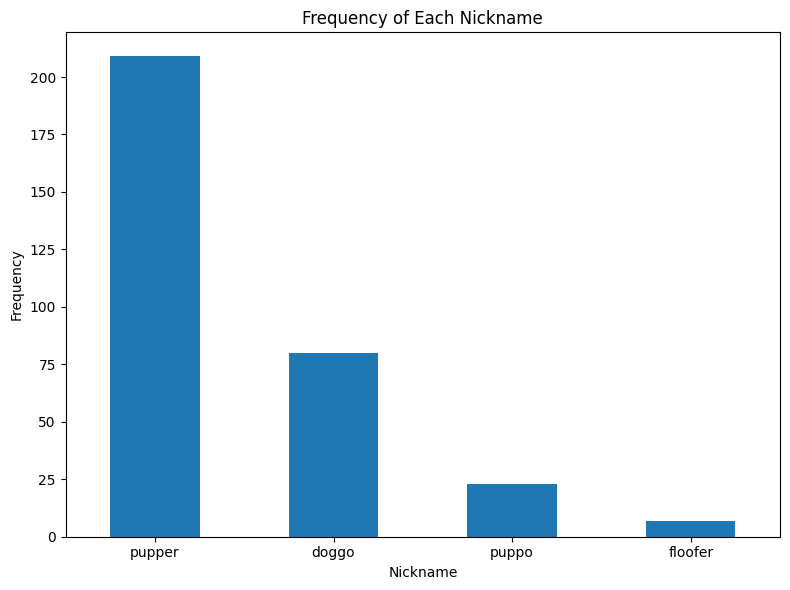

In [133]:
plt.figure(figsize=(8, 6))
twitter_df.loc[
    twitter_df["nickname"] != "-",
    "nickname"
].value_counts().plot(kind="bar")
plt.xlabel("Nickname")
plt.ylabel("Frequency")
plt.title("Frequency of Each Nickname")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Pupper won??!!
-# floofer was waay better